In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [4]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

# Load Connectivity

In [8]:
ref = 'bipolar'
task = ['LexicalDelay', 'PhonemeSequence']

paths = []
for t in task:
    paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='connectivity',
            suffix='pdc',
            extension='.h5',
            check=False,
        ).match()
    )

def package_connectivity_frame(file_path: BIDSPath) -> pd.DataFrame:
    """Load connectivity results from HDF5 to pandas DataFrame in long format.
    
    Parameters
    ----------
    file_path : BIDSPath
        Path to the connectivity HDF5 file
        
    Returns
    -------
    df : pd.DataFrame
        Long-format DataFrame with columns:
        - subject, description, time, source, target, pdc, pval
    """
    import json
    
    with h5py.File(file_path.fpath, 'r') as f:
        pdc = f['pdc'][:]  # (n_windows, n_channels, n_channels)
        pvals = f['pvals'][:]
        time_points = f['time_points'][:]
        
        # Metadata from attributes
        subject = f.attrs['subject']
        description = f.attrs['description']
        try:
            phase = f.attrs['phase']
        except:
            phase = None
        ch_names = json.loads(f.attrs['channel_names_json'])
        fs = f.attrs['fs']
        window = f.attrs['window']
        step = f.attrs['step']
    
    n_windows, n_channels, _ = pdc.shape
    
    # Build long-format records
    records = []
    for wi, t in enumerate(time_points):
        for si, source in enumerate(ch_names):
            for ti, target in enumerate(ch_names):
                if si != ti:  # Skip self-connections
                    records.append({
                        'subject': subject,
                        'phase': phase,
                        'description': description,
                        'time': t,
                        'source': source,
                        'target': target,
                        'pdc': pdc[wi, si, ti],
                        'pval': pvals[wi, si, ti],
                        'window': window,
                        'step': step,
                    })
    
    df = pd.DataFrame(records)
    return df

# 加载连接性文件，跳过损坏的文件
print(f"Found {len(paths)} connectivity files to load...")
dfs = []
skipped_files = []

for f in tqdm(paths, desc='Loading connectivity files'):
    try:
        df = package_connectivity_frame(f)
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {f.fpath.name}: {e}")
        skipped_files.append(f.fpath.name)

print(f"Successfully loaded {len(dfs)} files")
if skipped_files:
    print(f"Skipped {len(skipped_files)} problematic files")

pdc = pd.concat(dfs, ignore_index=True)

# remove the Decision part, and the Delay/Go part
pdc = pdc[pdc.description != 'Decision']
pdc = pdc[~pdc.phase.isin(['Delay','Go'])]

# rename phase=Audio to perception
pdc.phase = pdc.phase.replace('Audio', 'perception')
# rename phase=Response to action
pdc.phase = pdc.phase.replace('Resp', 'production')

pdc.loc[pdc.description == 'perception', 'phase'] = 'perception'
pdc.loc[pdc.description == 'production', 'phase'] = 'production'

Found 552 connectivity files to load...


Loading connectivity files: 100%|██████████| 552/552 [01:57<00:00,  4.71it/s]


Successfully loaded 552 files


## Merge channel info to connectivity

In [10]:
## Load coordinates and roi labels for source and target regions

ref = 'bipolar'
task = ['LexicalDelay', 'PhonemeSequence']
time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='coord',  # 注意这里改成 'coord'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
coords = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    coords.append(df)

coord_data = pd.concat(coords, ignore_index=True)
# drop duplicate rows
coord_data = coord_data.drop_duplicates()

roi_list = ['INS', 'MFG', 'SMC', 'STG', 'HG', 'SMG',
            'IFG', 'SFG', 'ITG', 'MTG',]

# take the channel
coord_data = coord_data[coord_data['roi'].isin(roi_list)]
coord_data.head()

100%|██████████| 412/412 [00:00<00:00, 474.99it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,phase,label,roi,hemi
36,D0023_RPSF12-13,16.070733,-6.734340,65.145443,0.088763,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_front_sup,SFG,R
37,D0023_RPSF13-14,16.844451,-5.836732,68.880586,0.033410,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_front_sup,SFG,R
52,D0023_R1MF14-15,56.249805,1.672702,35.132438,-0.104185,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_precentral,SMC,R
53,D0023_R1MF15-16,59.342169,1.616566,35.132369,-0.056052,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_G_precentral,SMC,R
61,D0023_R2MF9-10,36.417728,-8.358371,36.078040,-0.007189,False,D0023,LexicalDelay,highgamma,Decision,Audio,ctx_rh_S_precentral-inf-part,SMC,R


In [11]:
# 简化的内存优化方案
roi_list = ['INS', 'MFG', 'SMC', 'STG', 'HG', 'SMG', 'IFG', 'SFG', 'ITG', 'MTG']

# 创建坐标字典（去重）
coord_data_filtered = coord_data[coord_data['roi'].isin(roi_list)].drop_duplicates('channel', keep='first')
coord_lookup = coord_data_filtered.set_index('channel')[['x', 'y', 'z', 'roi', 'hemi', 'label']].to_dict('index')

# 过滤并添加坐标
coord_cols = ['x', 'y', 'z', 'roi', 'hemi', 'label']
for col in coord_cols:
    pdc[f'source_{col}'] = pdc['source'].map(lambda ch: coord_lookup.get(ch, {}).get(col, np.nan if col in ['x','y','z'] else ''))
    pdc[f'target_{col}'] = pdc['target'].map(lambda ch: coord_lookup.get(ch, {}).get(col, np.nan if col in ['x','y','z'] else ''))

# 过滤ROI和缺失值
pdc = pdc[(pdc['source_roi'].isin(roi_list)) & (pdc['target_roi'].isin(roi_list))]
pdc = pdc.dropna(subset=['source_x', 'source_y', 'source_z', 'target_x', 'target_y', 'target_z'])

pdc.head()

,subject,phase,description,time,source,target,pdc,pval,window,step,...,source_y,target_y,source_z,target_z,source_roi,target_roi,source_hemi,target_hemi,source_label,target_label
10584,D0022,production,production,-0.80,D0022_LMSF4-5,D0022_LPIF3-4,0.023648,0.387226,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf
10587,D0022,production,production,-0.80,D0022_LPIF3-4,D0022_LMSF4-5,0.028021,0.463074,0.2,0.01,...,-19.677040,53.991872,-2.311079,33.249195,INS,MFG,L,L,ctx_lh_S_circular_insula_inf,ctx_lh_G_front_middle
10596,D0022,production,production,-0.79,D0022_LMSF4-5,D0022_LPIF3-4,0.022974,0.479042,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf
10599,D0022,production,production,-0.79,D0022_LPIF3-4,D0022_LMSF4-5,0.021380,0.752495,0.2,0.01,...,-19.677040,53.991872,-2.311079,33.249195,INS,MFG,L,L,ctx_lh_S_circular_insula_inf,ctx_lh_G_front_middle
10608,D0022,production,production,-0.78,D0022_LMSF4-5,D0022_LPIF3-4,0.018245,0.674651,0.2,0.01,...,53.991872,-19.677040,33.249195,-2.311079,MFG,INS,L,L,ctx_lh_G_front_middle,ctx_lh_S_circular_insula_inf


# Viz channel-channel connectivity pairs

## Viz whole brain

Perception (0-0.5s) - Curved:
Plotting 200 curved connections for perception (0.00-0.50s)


2025-12-28 18:04:29.466 (10951.963s) [    7FE3D8B94440]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:29.591 (10952.087s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x7dfb6f0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:29.761 (10952.258s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x83f1e10): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D

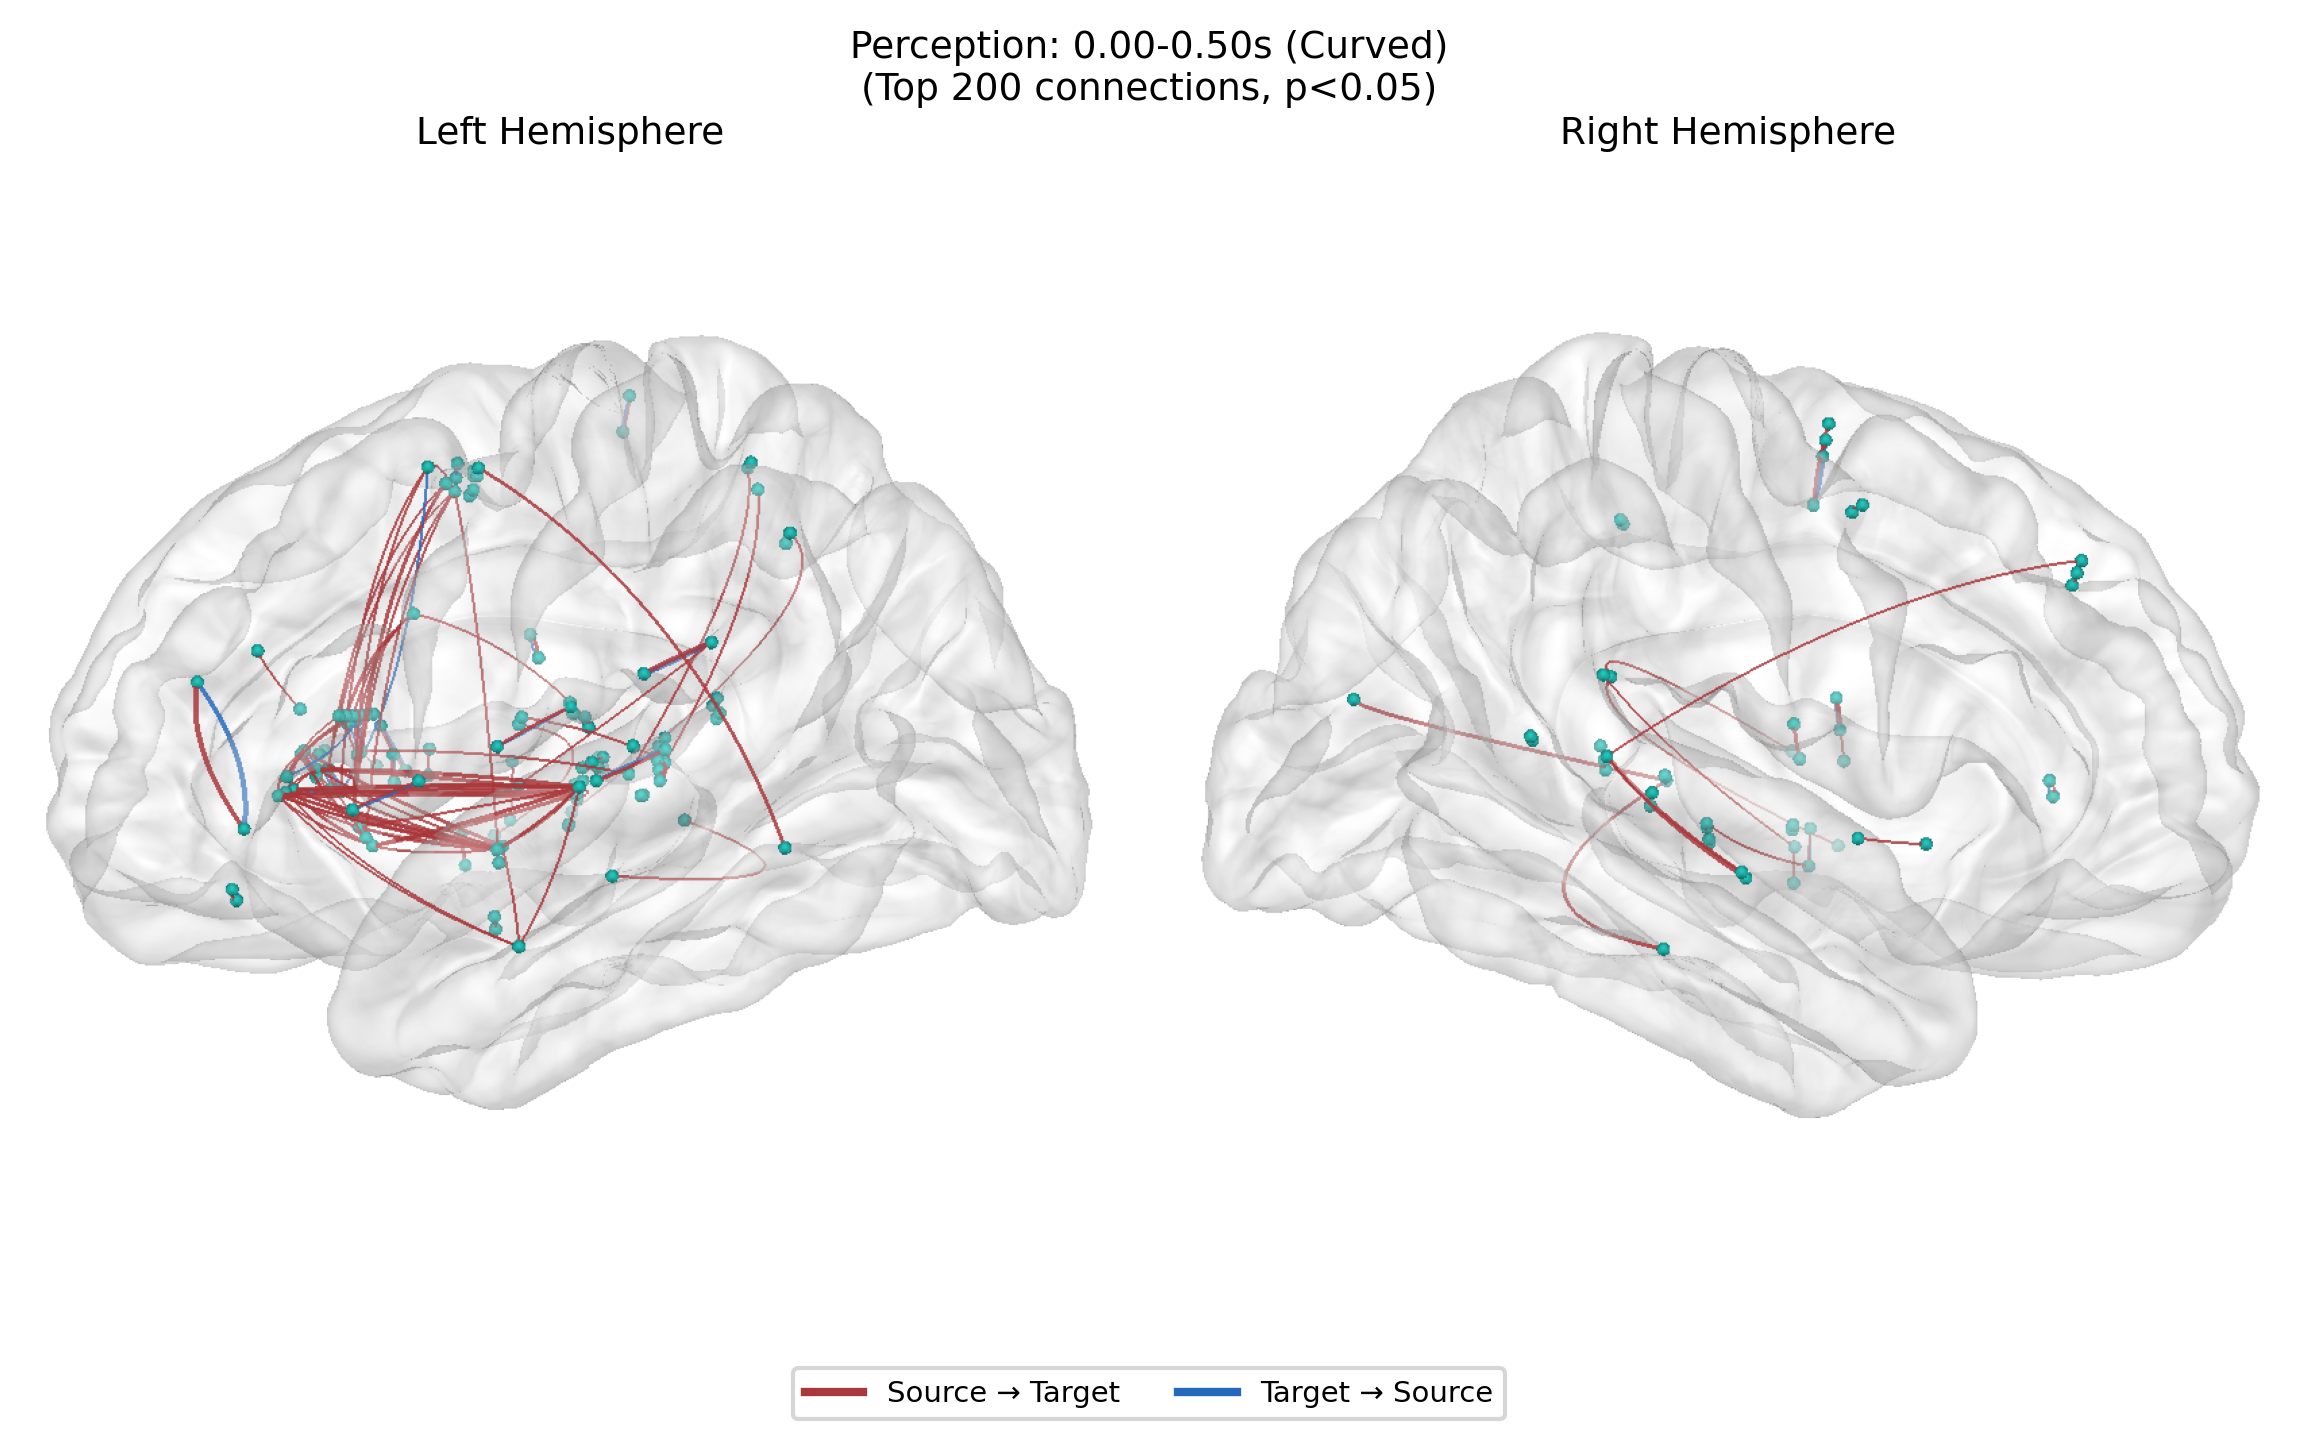

Plotting 200 curved connections for production (-0.50-0.00s)


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:49.716 (10972.213s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x177e5f750): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:49.750 (10972.247s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x16e16e800): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warni

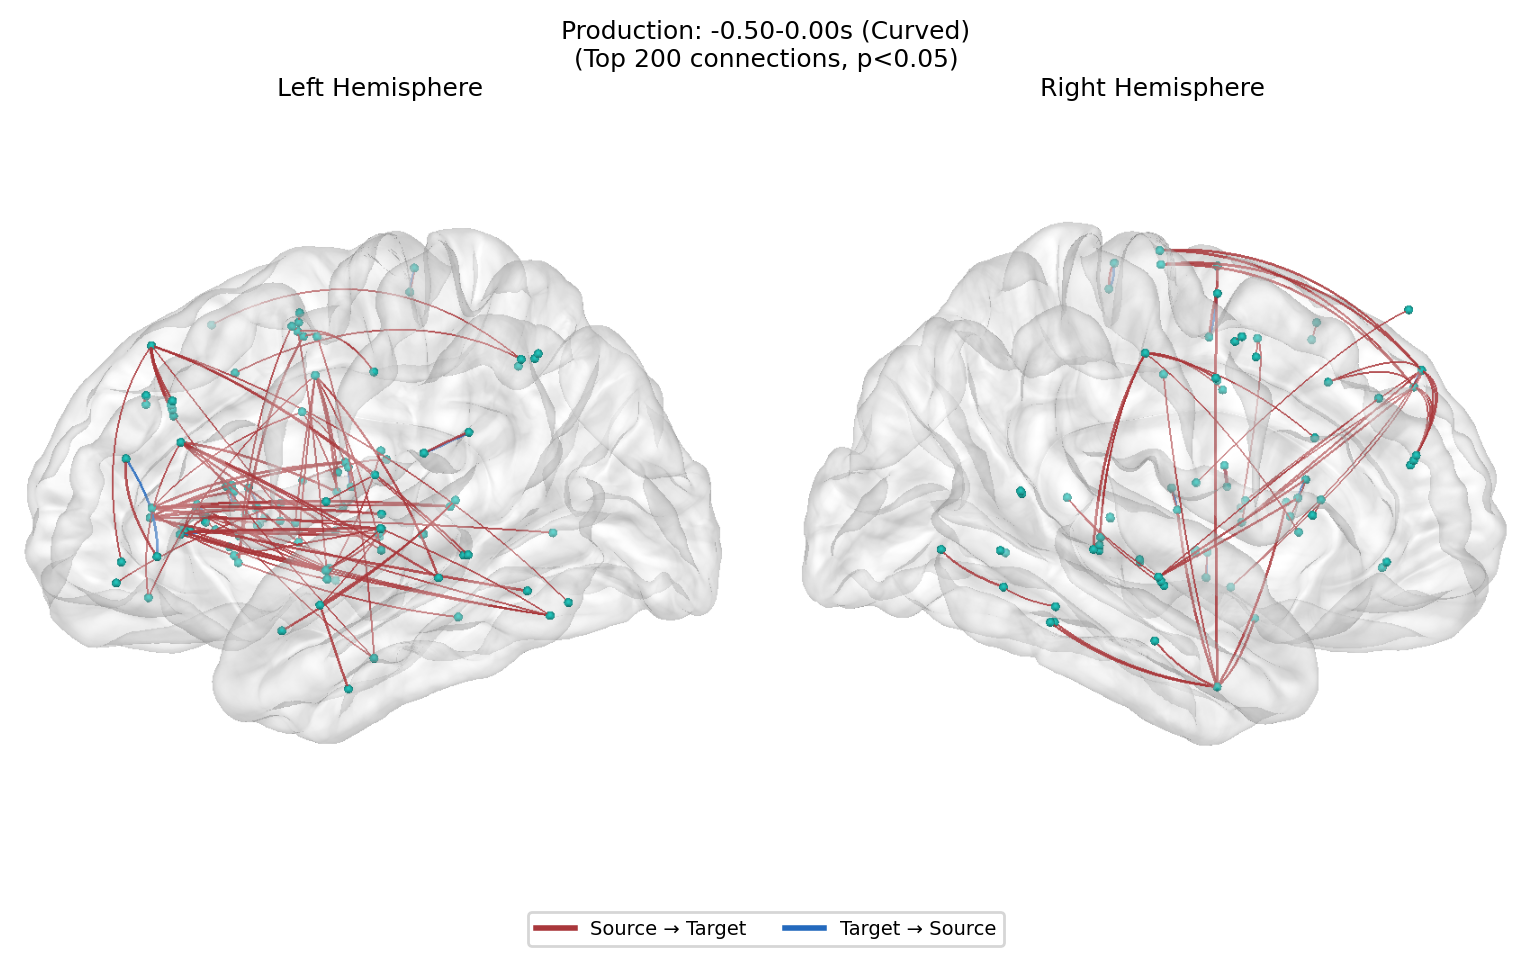

(<mne.viz._brain._brain.Brain at 0x7fe317f14050>,
 <mne.viz._brain._brain.Brain at 0x7fe316e00090>)

In [12]:
from mne.viz import Brain
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_bezier_curve(p0, p1, n_points=50, curvature=0.3):
    """创建两点之间的贝塞尔曲线。
    
    Parameters
    ----------
    p0, p1 : np.ndarray
        起点和终点坐标 (3,)
    n_points : int
        曲线上的点数
    curvature : float
        曲线弯曲程度 (0-1)
        
    Returns
    -------
    curve_points : np.ndarray
        曲线上的点 (n_points, 3)
    """
    p0 = np.array(p0)
    p1 = np.array(p1)
    
    # 计算中点
    mid = (p0 + p1) / 2
    
    # 计算垂直于连线的方向（向外弯曲）
    direction = p1 - p0
    length = np.linalg.norm(direction)
    
    # 使用叉积找到垂直方向（向外弯曲，远离脑中心）
    # 脑中心大约在原点，所以向外的方向是mid的方向
    center = np.array([0, 0, 0])
    outward = mid - center
    outward = outward / (np.linalg.norm(outward) + 1e-8)
    
    # 控制点：在中点向外偏移
    control = mid + outward * length * curvature
    
    # 生成二次贝塞尔曲线
    t = np.linspace(0, 1, n_points).reshape(-1, 1)
    curve = (1-t)**2 * p0 + 2*(1-t)*t * control + t**2 * p1
    
    return curve


def plot_connectivity_curved(
    pdc_df, 
    description='perception',
    time_window=(0, 0.5),
    alpha=0.05,
    top_n=50,
    hemi='both',
    view='lateral',
    line_width=2,
    curvature=0.25,
    figsize=(20, 12),
    dpi=150,
):
    """使用曲线在3D脑表面上可视化电极对之间的连接性。
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        包含连接性数据的DataFrame
    description : str
        'perception' 或 'production'
    time_window : tuple
        时间窗口 (tmin, tmax)
    alpha : float
        显著性阈值
    top_n : int
        显示前N个最强的连接
    hemi : str
        'lh', 'rh', 或 'both'
    view : str
        视角
    line_width : float
        连接线宽度
    curvature : float
        曲线弯曲程度 (0-1)
    figsize : tuple
        图像尺寸（厘米）
    dpi : int
        图像分辨率
    """
    # 筛选数据
    subset = pdc_df[
        (pdc_df['phase'] == description) &
        (pdc_df['time'] >= time_window[0]) &
        (pdc_df['time'] <= time_window[1]) &
        (pdc_df['pval'] < alpha)
    ].copy()
    
    if subset.empty:
        print(f"No significant connections for {description} in time window {time_window}")
        return None
    
    # 聚合: 对每个电极对计算平均PDC
    agg = subset.groupby(['source', 'target']).agg({
        'pdc': 'mean',
        'source_x': 'first', 'source_y': 'first', 'source_z': 'first',
        'target_x': 'first', 'target_y': 'first', 'target_z': 'first',
        'source_roi': 'first', 'target_roi': 'first',
    }).reset_index()
    
    # 选择top N个最强连接
    agg = agg.nlargest(top_n, 'pdc')
    
    # 标记双向连接
    processed_pairs = set()
    agg['is_reverse'] = False
    agg['has_reverse'] = False
    
    for idx, row in agg.iterrows():
        pair = tuple(sorted([row['source'], row['target']]))
        if pair in processed_pairs:
            agg.loc[idx, 'is_reverse'] = True
        else:
            # 检查是否存在反向连接
            reverse_exists = ((agg['source'] == row['target']) & (agg['target'] == row['source'])).any()
            agg.loc[idx, 'has_reverse'] = reverse_exists
            processed_pairs.add(pair)
    
    print(f"Plotting {len(agg)} curved connections for {description} ({time_window[0]:.2f}-{time_window[1]:.2f}s)")
    
    brain_size = (800, 800)
    
    if hemi == 'both':
        lh_brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi="lh", background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        rh_brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi="rh", background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        
        all_electrodes_lh = []
        all_electrodes_rh = []
        
        for _, row in agg.iterrows():
            src_coord = np.array([row['source_x'], row['source_y'], row['source_z']])
            tgt_coord = np.array([row['target_x'], row['target_y'], row['target_z']])
            pdc_val = row['pdc']
            
            # 颜色：红色正向，蓝色反向
            if row['is_reverse']:
                color = blue
                curve_dir = -1  # 反向曲线弯曲方向相反
            else:
                color = red
                curve_dir = 1
            
            # 创建曲线
            curve_points = create_bezier_curve(src_coord, tgt_coord, n_points=30, curvature=curvature * curve_dir)
            
            # 创建pyvista的线条
            spline = pv.Spline(curve_points, n_points=30)
            lw = line_width * (pdc_val / agg['pdc'].max() * 1.5 + 0.5)
            
            mid_x = (src_coord[0] + tgt_coord[0]) / 2
            
            if mid_x < 0:  # 左半球
                lh_brain._renderer.plotter.add_mesh(
                    spline, color=color, line_width=lw, opacity=0.85
                )
                all_electrodes_lh.extend([src_coord, tgt_coord])
            else:  # 右半球
                rh_brain._renderer.plotter.add_mesh(
                    spline, color=color, line_width=lw, opacity=0.85
                )
                all_electrodes_rh.extend([src_coord, tgt_coord])
        
        # 添加电极点
        if all_electrodes_lh:
            electrodes_lh = np.unique(np.array(all_electrodes_lh), axis=0)
            lh_brain._renderer.plotter.add_mesh(
                pv.PolyData(electrodes_lh),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        if all_electrodes_rh:
            electrodes_rh = np.unique(np.array(all_electrodes_rh), axis=0)
            rh_brain._renderer.plotter.add_mesh(
                pv.PolyData(electrodes_rh),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        
        lh_brain.show_view(view)
        rh_brain.show_view(view)
        
        lh_img = lh_brain.screenshot(mode="rgb")
        rh_img = rh_brain.screenshot(mode="rgb")
        
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0]*cm, figsize[1]*cm), dpi=dpi)
        axes[0].imshow(lh_img)
        axes[0].axis('off')
        axes[0].set_title('Left Hemisphere', fontsize=fontsize+2)
        axes[1].imshow(rh_img)
        axes[1].axis('off')
        axes[1].set_title('Right Hemisphere', fontsize=fontsize+2)
        
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=red, linewidth=2, label='Source → Target'),
            Line2D([0], [0], color=blue, linewidth=2, label='Target → Source'),
        ]
        fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=fontsize)
        
        fig.suptitle(f'{description.capitalize()}: {time_window[0]:.2f}-{time_window[1]:.2f}s (Curved)\n(Top {len(agg)} connections, p<{alpha})', 
                     fontsize=fontsize+2)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.12)
        plt.show()
        
        return lh_brain, rh_brain
    
    else:
        brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi=hemi, background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        
        all_electrodes = []
        for _, row in agg.iterrows():
            src_coord = np.array([row['source_x'], row['source_y'], row['source_z']])
            tgt_coord = np.array([row['target_x'], row['target_y'], row['target_z']])
            pdc_val = row['pdc']
            
            if row['is_reverse']:
                color = blue
                curve_dir = -1
            else:
                color = red
                curve_dir = 1
            
            curve_points = create_bezier_curve(src_coord, tgt_coord, n_points=30, curvature=curvature * curve_dir)
            spline = pv.Spline(curve_points, n_points=30)
            lw = line_width * (pdc_val / agg['pdc'].max() * 1.5 + 0.5)
            
            brain._renderer.plotter.add_mesh(
                spline, color=color, line_width=lw, opacity=0.85
            )
            all_electrodes.extend([src_coord, tgt_coord])
        
        if all_electrodes:
            electrodes = np.unique(np.array(all_electrodes), axis=0)
            brain._renderer.plotter.add_mesh(
                pv.PolyData(electrodes),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        
        brain.show_view(view)
        return brain


# 示例: 曲线版本可视化
print("Perception (0-0.5s) - Curved:")
plot_connectivity_curved(pdc, 'perception', time_window=(0, 0.5), top_n=200, curvature=0.3, dpi=300)

# print("\nProduction (-0.5-0s) - Curved:")
plot_connectivity_curved(pdc, 'production', time_window=(-0.5, 0), top_n=200, curvature=0.25, dpi=200)

## Viz just insula

Insula Connectivity - Perception (0-0.5s):

Insula Connectivity - Production (-0.5-0s):
Plotting 100 Insula connections for production (-0.50-0.00s)
  - From Insula (red): 80
  - To Insula (blue): 20


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:55.952 (10978.449s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1854f4fe0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-28 18:04:55.985 (10978.482s) [    7FE3D8B94440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1835879a0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warni

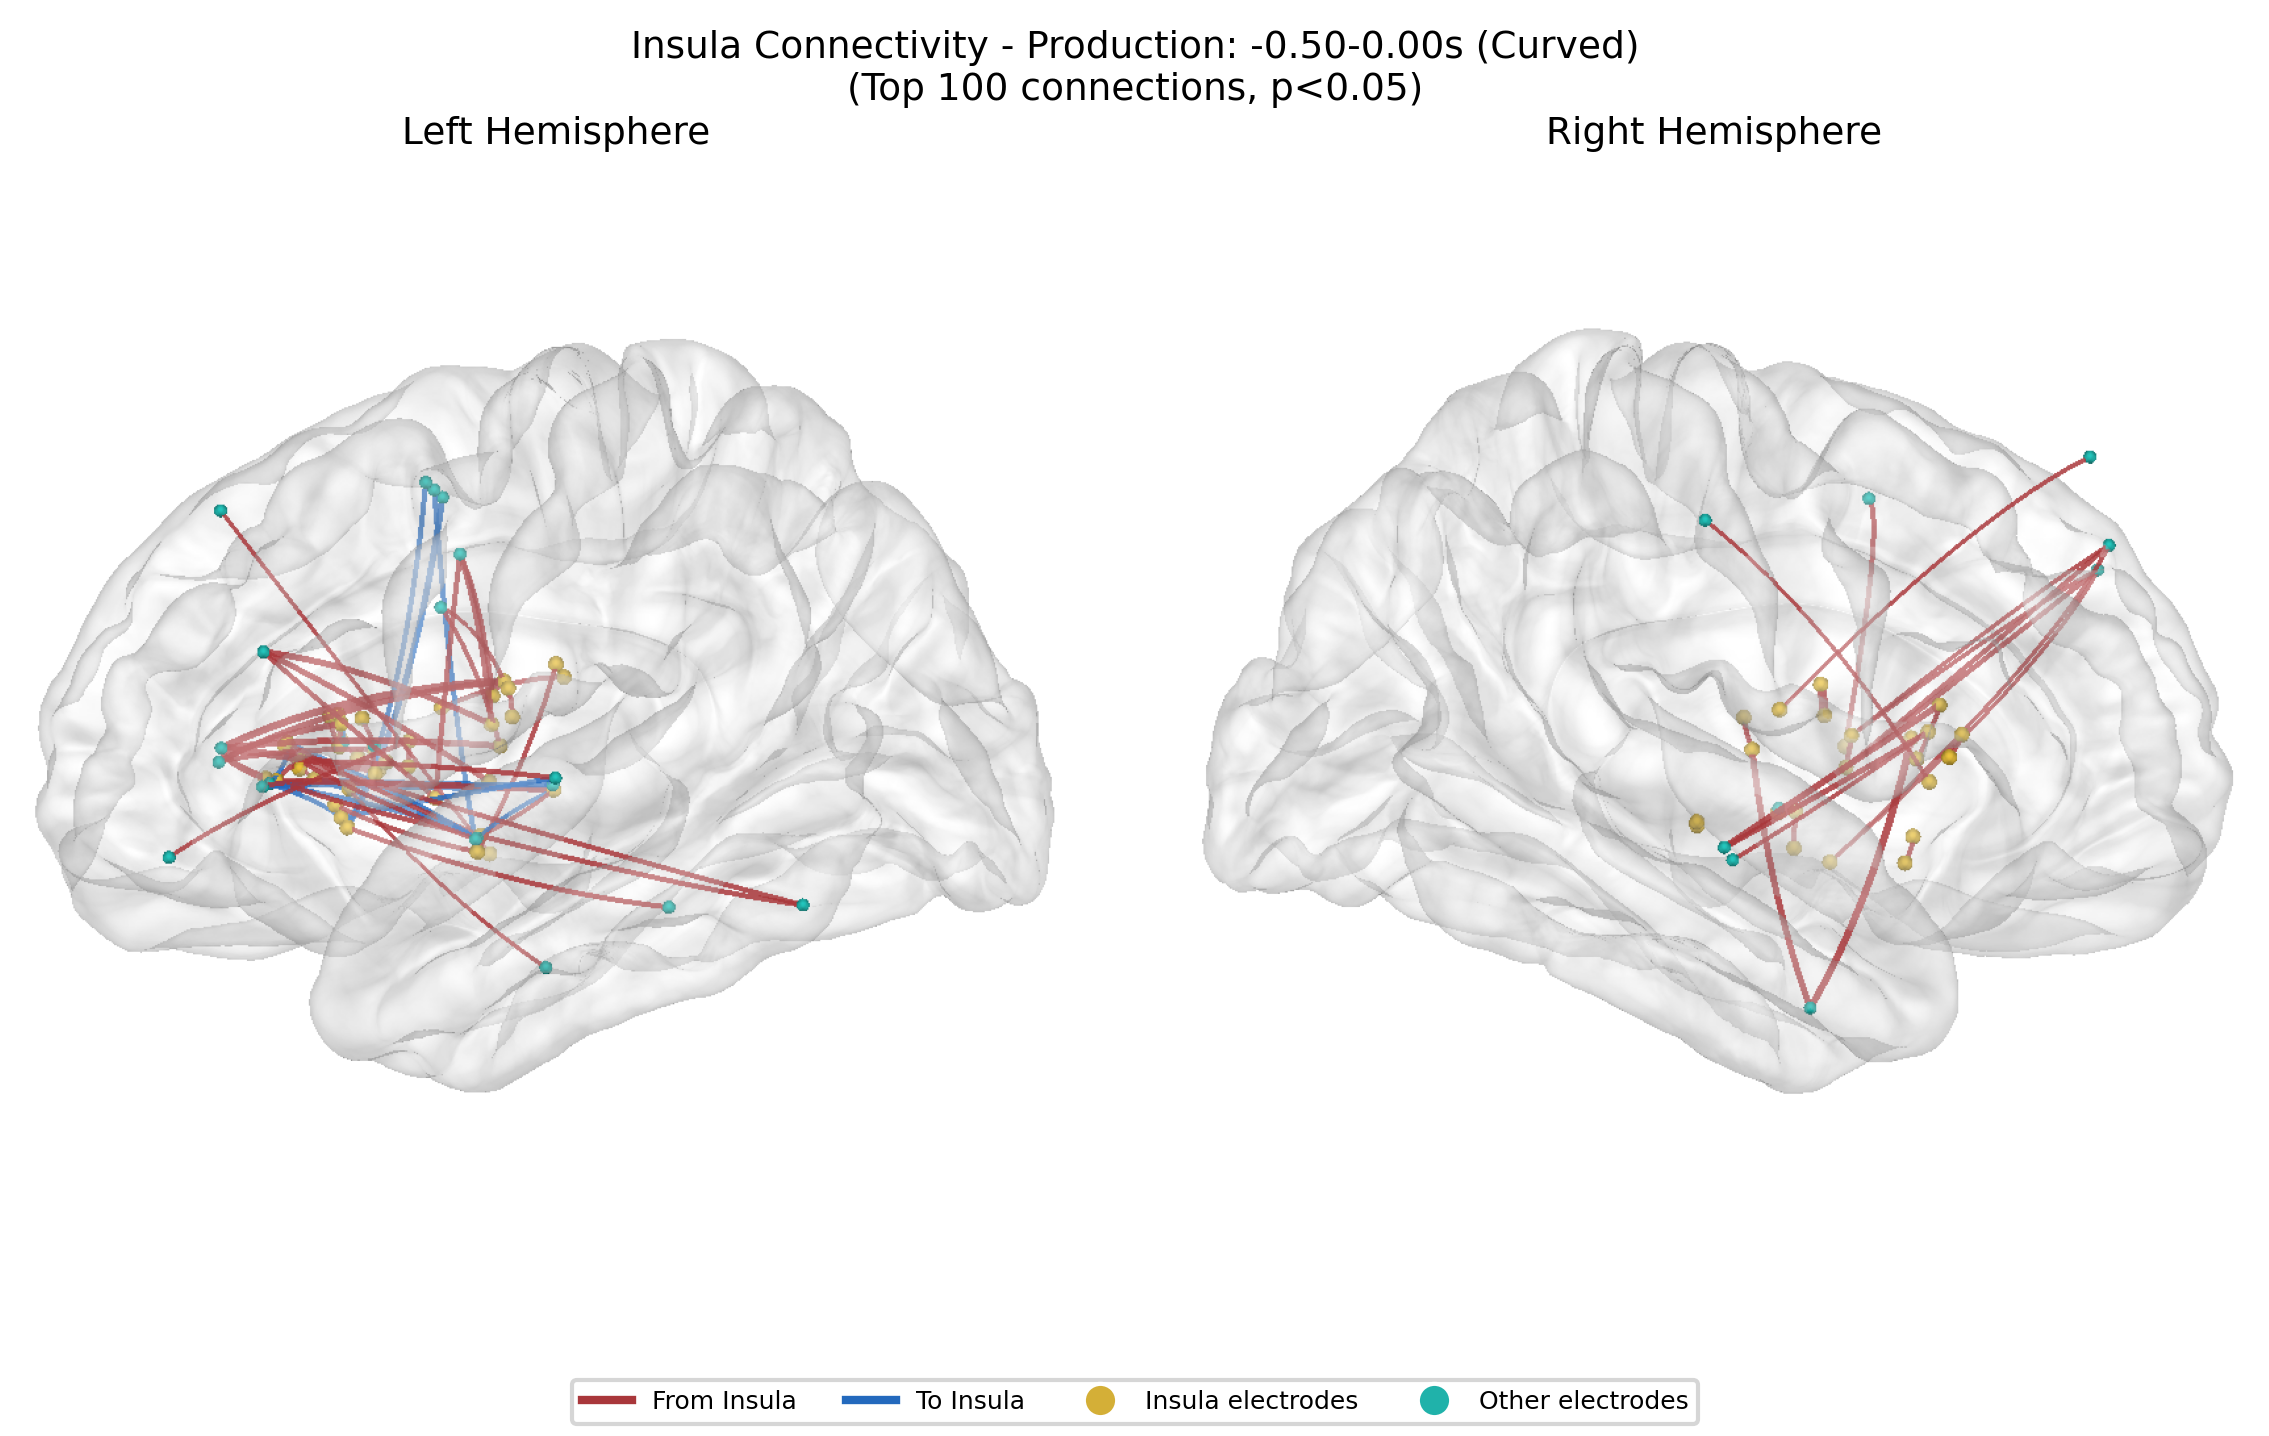

(<mne.viz._brain._brain.Brain at 0x7fe3106ddf10>,
 <mne.viz._brain._brain.Brain at 0x7fe3106dc2d0>)

In [13]:
# =============================================================================
# Insula 相关连接专用可视化
# 只显示 source 或 target 在 Insula 的连接
# =============================================================================

def plot_insula_connectivity(
    pdc_df, 
    description='perception',
    time_window=(0, 0.5),
    alpha=0.05,
    top_n=50,
    hemi='both',
    view='lateral',
    line_width=2,
    curvature=0.25,
    use_curved=True,
    figsize=(20, 12),
    dpi=150,
):
    """可视化与Insula相关的连接（source或target在Insula）。
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        包含连接性数据的DataFrame，需要有source_roi和target_roi列
    description : str
        'perception' 或 'production'
    time_window : tuple
        时间窗口 (tmin, tmax)
    alpha : float
        显著性阈值
    top_n : int
        显示前N个最强的连接
    hemi : str
        'lh', 'rh', 或 'both'
    view : str
        视角
    line_width : float
        连接线宽度
    curvature : float
        曲线弯曲程度 (0-1)，仅当use_curved=True时有效
    use_curved : bool
        是否使用曲线
    figsize : tuple
        图像尺寸（厘米）
    dpi : int
        图像分辨率
    """
    # 筛选数据 - 只保留与Insula相关的连接
    subset = pdc_df[
        (pdc_df['phase'] == description) &
        (pdc_df['time'] >= time_window[0]) &
        (pdc_df['time'] <= time_window[1]) &
        (pdc_df['pval'] < alpha) &
        ((pdc_df['source_roi'].str.contains('INS', case=False, na=False)) | 
         (pdc_df['target_roi'].str.contains('INS', case=False, na=False)))
    ].copy()
    
    if subset.empty:
        print(f"No significant Insula connections for {description} in time window {time_window}")
        return None
    
    # 聚合
    agg = subset.groupby(['source', 'target']).agg({
        'pdc': 'mean',
        'source_x': 'first', 'source_y': 'first', 'source_z': 'first',
        'target_x': 'first', 'target_y': 'first', 'target_z': 'first',
        'source_roi': 'first', 'target_roi': 'first',
    }).reset_index()
    
    # 选择top N
    agg = agg.nlargest(top_n, 'pdc')
    
    # 标记连接类型：from_insula (红色) 或 to_insula (蓝色)
    agg['from_insula'] = agg['source_roi'].str.contains('INS', case=False, na=False)
    agg['to_insula'] = agg['target_roi'].str.contains('INS', case=False, na=False)
    
    n_from = agg['from_insula'].sum()
    n_to = (~agg['from_insula'] & agg['to_insula']).sum()
    
    print(f"Plotting {len(agg)} Insula connections for {description} ({time_window[0]:.2f}-{time_window[1]:.2f}s)")
    print(f"  - From Insula (red): {n_from}")
    print(f"  - To Insula (blue): {n_to}")
    
    brain_size = (800, 800)
    
    if hemi == 'both':
        lh_brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi="lh", background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        rh_brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi="rh", background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        
        insula_electrodes_lh = []
        insula_electrodes_rh = []
        other_electrodes_lh = []
        other_electrodes_rh = []
        
        for _, row in agg.iterrows():
            src_coord = np.array([row['source_x'], row['source_y'], row['source_z']])
            tgt_coord = np.array([row['target_x'], row['target_y'], row['target_z']])
            pdc_val = row['pdc']
            
            # 颜色：红色从Insula出发，蓝色到Insula
            if row['from_insula']:
                color = red
                curve_dir = 1
            else:
                color = blue
                curve_dir = -1
            
            lw = line_width * (pdc_val / agg['pdc'].max() * 3 + 0.5)
            mid_x = (src_coord[0] + tgt_coord[0]) / 2
            
            if use_curved:
                curve_points = create_bezier_curve(src_coord, tgt_coord, n_points=30, curvature=curvature * curve_dir)
                mesh = pv.Spline(curve_points, n_points=30)
            else:
                mesh = pv.Line(src_coord, tgt_coord)
            
            # 收集电极坐标并标记是否为Insula
            src_is_ins = 'INS' in str(row['source_roi']).upper()
            tgt_is_ins = 'INS' in str(row['target_roi']).upper()
            
            if mid_x < 0:  # 左半球
                lh_brain._renderer.plotter.add_mesh(
                    mesh, color=color, line_width=lw, opacity=0.85
                )
                if src_is_ins:
                    insula_electrodes_lh.append(src_coord)
                else:
                    other_electrodes_lh.append(src_coord)
                if tgt_is_ins:
                    insula_electrodes_lh.append(tgt_coord)
                else:
                    other_electrodes_lh.append(tgt_coord)
            else:  # 右半球
                rh_brain._renderer.plotter.add_mesh(
                    mesh, color=color, line_width=lw, opacity=0.85
                )
                if src_is_ins:
                    insula_electrodes_rh.append(src_coord)
                else:
                    other_electrodes_rh.append(src_coord)
                if tgt_is_ins:
                    insula_electrodes_rh.append(tgt_coord)
                else:
                    other_electrodes_rh.append(tgt_coord)
        
        # 添加电极点 - Insula用金色，其他用青色
        if insula_electrodes_lh:
            ins_lh = np.unique(np.array(insula_electrodes_lh), axis=0)
            lh_brain._renderer.plotter.add_mesh(
                pv.PolyData(ins_lh),
                render_points_as_spheres=True, point_size=12,
                color=insula_color, opacity=1
            )
        if other_electrodes_lh:
            other_lh = np.unique(np.array(other_electrodes_lh), axis=0)
            lh_brain._renderer.plotter.add_mesh(
                pv.PolyData(other_lh),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        if insula_electrodes_rh:
            ins_rh = np.unique(np.array(insula_electrodes_rh), axis=0)
            rh_brain._renderer.plotter.add_mesh(
                pv.PolyData(ins_rh),
                render_points_as_spheres=True, point_size=12,
                color=insula_color, opacity=1
            )
        if other_electrodes_rh:
            other_rh = np.unique(np.array(other_electrodes_rh), axis=0)
            rh_brain._renderer.plotter.add_mesh(
                pv.PolyData(other_rh),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        
        lh_brain.show_view(view)
        rh_brain.show_view(view)
        
        lh_img = lh_brain.screenshot(mode="rgb")
        rh_img = rh_brain.screenshot(mode="rgb")
        
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0]*cm, figsize[1]*cm), dpi=dpi)
        axes[0].imshow(lh_img)
        axes[0].axis('off')
        axes[0].set_title('Left Hemisphere', fontsize=fontsize+2)
        axes[1].imshow(rh_img)
        axes[1].axis('off')
        axes[1].set_title('Right Hemisphere', fontsize=fontsize+2)
        
        from matplotlib.lines import Line2D
        from matplotlib.patches import Circle
        legend_elements = [
            Line2D([0], [0], color=red, linewidth=2, label='From Insula'),
            Line2D([0], [0], color=blue, linewidth=2, label='To Insula'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=insula_color, 
                   markersize=8, label='Insula electrodes'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=stg_color, 
                   markersize=8, label='Other electrodes'),
        ]
        fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=fontsize-1)
        
        curve_label = " (Curved)" if use_curved else ""
        fig.suptitle(f'Insula Connectivity - {description.capitalize()}: {time_window[0]:.2f}-{time_window[1]:.2f}s{curve_label}\n(Top {len(agg)} connections, p<{alpha})', 
                     fontsize=fontsize+2)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.14)
        plt.show()
        
        return lh_brain, rh_brain
    
    else:
        brain = Brain(
            "fsaverage", subjects_dir=recon_dir, surf="pial",
            hemi=hemi, background="white", show=False,
            cortex=(0.9, 0.9, 0.9), alpha=0.3, size=brain_size
        )
        
        insula_electrodes = []
        other_electrodes = []
        
        for _, row in agg.iterrows():
            src_coord = np.array([row['source_x'], row['source_y'], row['source_z']])
            tgt_coord = np.array([row['target_x'], row['target_y'], row['target_z']])
            pdc_val = row['pdc']
            
            if row['from_insula']:
                color = red
                curve_dir = 1
            else:
                color = blue
                curve_dir = -1
            
            lw = line_width * (pdc_val / agg['pdc'].max() * 3 + 0.5)
            
            if use_curved:
                curve_points = create_bezier_curve(src_coord, tgt_coord, n_points=30, curvature=curvature * curve_dir)
                mesh = pv.Spline(curve_points, n_points=30)
            else:
                mesh = pv.Line(src_coord, tgt_coord)
            
            brain._renderer.plotter.add_mesh(
                mesh, color=color, line_width=lw, opacity=0.85
            )
            
            src_is_ins = 'INS' in str(row['source_roi']).upper()
            tgt_is_ins = 'INS' in str(row['target_roi']).upper()
            
            if src_is_ins:
                insula_electrodes.append(src_coord)
            else:
                other_electrodes.append(src_coord)
            if tgt_is_ins:
                insula_electrodes.append(tgt_coord)
            else:
                other_electrodes.append(tgt_coord)
        
        if insula_electrodes:
            ins_elec = np.unique(np.array(insula_electrodes), axis=0)
            brain._renderer.plotter.add_mesh(
                pv.PolyData(ins_elec),
                render_points_as_spheres=True, point_size=12,
                color=insula_color, opacity=1
            )
        if other_electrodes:
            other_elec = np.unique(np.array(other_electrodes), axis=0)
            brain._renderer.plotter.add_mesh(
                pv.PolyData(other_elec),
                render_points_as_spheres=True, point_size=10,
                color=stg_color, opacity=1
            )
        
        brain.show_view(view)
        return brain


# 示例: Insula连接可视化
print("Insula Connectivity - Perception (0-0.5s):")
# plot_insula_connectivity(pdc, 'perception', time_window=(0, 0.2), top_n=20, use_curved=True, dpi=300)

print("\nInsula Connectivity - Production (-0.5-0s):")
plot_insula_connectivity(pdc, 'production', time_window=(-0.5, 0), top_n=100, use_curved=True, dpi=300)

# NMF on (label, label, time) connectivity

In [67]:
def extract_label_connectivity_matrix(
    pdc_df,
    description,
    alpha=0.05,
    mask_nonsig=False,
    window=(0, 0.5),
    agg_method='mean'
):
    """extract aparc2009s label, pool across subjects
    
    Parameters
    ----------
    pdc_df : pd.DataFrame
        DataFrame in long_format, need source_label and target_label columns
    description : str
        'perception' 或 'production'
    alpha : float
        显著性阈值
    mask_nonsig : bool
        mask nonsignificant connections
    agg_method : str
        method for aggregation: 'mean', 'median', 'max'
        
    Returns
    -------
    conn_matrix : np.ndarray
        Shape (n_labels, n_labels, n_times)
    labels : list
        Label list
    times : np.ndarray
        time points
    """
    subset = pdc_df[(pdc_df['phase'] == description) & 
                    (pdc_df['time'] >= window[0]) & 
                    (pdc_df['time'] <= window[1])].copy()
    
    if subset.empty:
        raise ValueError(f"No data for {description}")
    
    # 移除NaN的label（某些电极可能没有label）
    subset = subset.dropna(subset=['source_label', 'target_label'])
    
    if subset.empty:
        raise ValueError(f"No valid label data for {description}")
    
    # 获取唯一label和时间点 - 从source_label和target_label获取
    labels = sorted(set(subset['source_label'].unique()) | set(subset['target_label'].unique()))
    times = np.sort(subset['time'].unique())
    
    n_labels = len(labels)
    n_times = len(times)
    
    # 创建label索引映射
    label_to_idx = {label: i for i, label in enumerate(labels)}
    
    # 初始化矩阵
    conn_matrix = np.full((n_labels, n_labels, n_times), np.nan)
    
    # 聚合: 对每个(source_label, target_label, time)计算统计量
    agg_funcs = {'mean': 'mean', 'median': 'median', 'max': 'max'}
    
    agg = subset.groupby(['source_label', 'target_label', 'time']).agg({
        'pdc': agg_funcs.get(agg_method, 'mean'),
        'pval': 'mean'  # 平均p值用于判断显著性
    }).reset_index()
    
    # 填充矩阵
    for _, row in agg.iterrows():
        src_label = row['source_label']
        tgt_label = row['target_label']
        
        # 检查label是否在映射中（处理可能的edge case）
        if src_label not in label_to_idx or tgt_label not in label_to_idx:
            continue
            
        si = label_to_idx[src_label]
        ti = label_to_idx[tgt_label]
        t_idx = np.where(np.isclose(times, row['time']))[0]
        
        if len(t_idx) == 0:
            continue
        t_idx = t_idx[0]
        
        if mask_nonsig:
            if row['pval'] < alpha:
                conn_matrix[si, ti, t_idx] = row['pdc']
        else:
            conn_matrix[si, ti, t_idx] = row['pdc']
    
    return conn_matrix, labels, times


perception_conn, perception_labels, perception_time = extract_label_connectivity_matrix(
    pdc, 'perception', alpha=0.05, mask_nonsig=True, window=(-0.5, 0.5),
)

production_conn, production_labels, production_time = extract_label_connectivity_matrix(
    pdc, 'production', alpha=0.05, mask_nonsig=True, window=(-0.5, 0.5),
)

print(f"\nLabel-level connectivity matrix (production):")
print(f"  Shape: {production_conn.shape} (labels, labels, time)")
print(f"  Number of labels: {len(production_labels)}")
print(f"\nLabels: {production_labels[:10]}...")  # 只显示前10个


Label-level connectivity matrix (production):
  Shape: (45, 45, 100) (labels, labels, time)
  Number of labels: 45

Labels: ['ctx_lh_G_Ins_lg_and_S_cent_ins', 'ctx_lh_G_and_S_subcentral', 'ctx_lh_G_front_inf-Opercular', 'ctx_lh_G_front_inf-Orbital', 'ctx_lh_G_front_inf-Triangul', 'ctx_lh_G_front_middle', 'ctx_lh_G_front_sup', 'ctx_lh_G_insular_short', 'ctx_lh_G_pariet_inf-Supramar', 'ctx_lh_G_postcentral']...


In [68]:
# find insula labels
labels_list = production_labels

insula_labels = [label for label in labels_list if 'insul' in label.lower()]
print(f"Found {len(insula_labels)} insula labels:")
for label in insula_labels:
    print(f"  {label}")

# create insula indices
insula_indices = {i for i, label in enumerate(labels_list) if 'insul' in label.lower()}

# copy and mask non-insula connections
perception_conn_insula = perception_conn.copy()
production_conn_insula = production_conn.copy()

# traverse all connections and mask non-insula connections
for i in range(len(labels_list)):
    for j in range(len(labels_list)):
        if i not in insula_indices and j not in insula_indices:
            perception_conn_insula[i, j, :] = np.nan
            production_conn_insula[i, j, :] = np.nan


Found 6 insula labels:
  ctx_lh_G_insular_short
  ctx_lh_S_circular_insula_inf
  ctx_lh_S_circular_insula_sup
  ctx_rh_G_insular_short
  ctx_rh_S_circular_insula_inf
  ctx_rh_S_circular_insula_sup


In [69]:
# Prepare data for NMF: reshape (roi, roi, time) -> (roi*roi, time) and handle NaN
def prepare_for_nmf(conn_matrix, normalize_method='none'):
    """Reshape connectivity matrix for NMF and handle NaN values.
    
    NMF requires non-negative values, so we'll handle NaN values and optionally normalize.
    
    Parameters
    ----------
    conn_matrix : np.ndarray
        Shape (n_roi, n_roi, n_times)
    normalize_method : str
        Normalization method: 'none', 'zscore', 'max', 'log'
        
    Returns
    -------
    data_matrix : np.ndarray
        Shape (n_roi*n_roi, n_times) ready for NMF
    valid_mask : np.ndarray
        Boolean mask of which connections are valid (not all NaN)
    """
    n_roi, n_roi2, n_times = conn_matrix.shape
    assert n_roi == n_roi2, "Matrix must be square"
    
    # Step 1: Apply normalization if requested
    if normalize_method == 'none':
        conn_normalized = conn_matrix.copy()
    
    elif normalize_method == 'zscore':
        # Z-score normalization for each connection over time
        conn_normalized = np.zeros_like(conn_matrix)
        for i in range(n_roi):
            for j in range(n_roi):
                ts = conn_matrix[i, j, :]
                valid = ~np.isnan(ts)
                if np.sum(valid) > 0:
                    mean_val = np.nanmean(ts)
                    std_val = np.nanstd(ts)
                    if std_val > 0:
                        conn_normalized[i, j, valid] = (ts[valid] - mean_val) / std_val
                    else:
                        conn_normalized[i, j, valid] = 0  # constant time series
                else:
                    conn_normalized[i, j, :] = 0
    
    elif normalize_method == 'max':
        # Max normalization for each connection
        conn_normalized = np.zeros_like(conn_matrix)
        for i in range(n_roi):
            for j in range(n_roi):
                ts = conn_matrix[i, j, :]
                valid = ~np.isnan(ts)
                if np.sum(valid) > 0:
                    max_val = np.nanmax(ts)
                    if max_val > 0:
                        conn_normalized[i, j, valid] = ts[valid] / max_val
                    else:
                        conn_normalized[i, j, valid] = 0
                else:
                    conn_normalized[i, j, :] = 0
    
    else:
        raise ValueError(f"Unknown normalization method: {normalize_method}")
    
    # Step 2: Reshape to (n_connections, n_times)
    data_2d = conn_normalized.reshape(n_roi * n_roi, n_times)
    
    # Step 3: Handle NaN values - replace with 0 and create mask
    valid_mask = ~np.isnan(data_2d)
    data_clean = np.where(valid_mask, data_2d, 0)
    
    # Step 4: Make non-negative for NMF (if needed)
    if normalize_method == 'zscore':
        # For z-score, shift to be non-negative
        min_val = np.min(data_clean[valid_mask])
        if min_val < 0:
            data_clean = data_clean - min_val
    
    print(f"Normalization: {normalize_method}")
    print(f"  Valid connections: {np.sum(np.any(valid_mask, axis=1))} / {n_roi * n_roi}")
    print(f"  Data range: [{np.min(data_clean):.3f}, {np.max(data_clean):.3f}]")
    
    return data_clean, valid_mask

In [70]:
def run_nmf_connectivity(data_matrix, n_components=5, random_state=42, max_iter=500):
    """
    Apply Non-negative Matrix Factorization (NMF) to connectivity data.
    
    Parameters
    ----------
    data_matrix : np.ndarray
        Input data matrix with shape (n_connections, n_timepoints)
        Should be non-negative (handle NaN values before calling)
    n_components : int
        Number of NMF components to extract
    random_state : int
        Random seed for reproducibility
    max_iter : int
        Maximum number of iterations for NMF
        
    Returns
    -------
    W : np.ndarray
        Spatial components matrix with shape (n_connections, n_components)
    H : np.ndarray  
        Temporal components matrix with shape (n_components, n_timepoints)
    nmf_model : sklearn.decomposition.NMF
        Fitted NMF model object
    """
    from sklearn.decomposition import NMF
    
    print(f"Running NMF with {n_components} components...")
    
    # Initialize NMF model
    nmf = NMF(
        n_components=n_components,
        init='nndsvda',  # Better initialization for connectivity data
        random_state=random_state,
        max_iter=max_iter,
        alpha_W=0.0,  # No regularization
        alpha_H=0.0,  # No regularization
        l1_ratio=0.0,  # No L1 regularization
        verbose=0
    )
    
    # Fit NMF model
    W = nmf.fit_transform(data_matrix)
    H = nmf.components_
    
    # Calculate reconstruction error
    reconstruction_error = nmf.reconstruction_err_
    print(f"NMF reconstruction error: {reconstruction_error:.4f}")
    
    # Print convergence info
    if nmf.n_iter_ < max_iter:
        print(f"NMF converged after {nmf.n_iter_} iterations")
    else:
        print(f"NMF reached maximum iterations ({max_iter})")
    
    return W, H, nmf


In [83]:
X_perception, mask_perception = prepare_for_nmf(perception_conn, normalize_method='none')
X_production, mask_production = prepare_for_nmf(production_conn, normalize_method='none')

from sklearn.decomposition import NMF

n_components = 10
W_perception, H_perception, nmf_perception = run_nmf_connectivity(X_perception, n_components=n_components)
W_production, H_production, nmf_production = run_nmf_connectivity(X_production, n_components=n_components)

n_labels = len(perception_labels)
W_perception = W_perception.reshape((n_labels, n_labels, n_components))
n_labels = len(production_labels)
W_production = W_production.reshape((n_labels, n_labels, n_components))

Normalization: none
  Valid connections: 144 / 2116
  Data range: [0.000, 0.297]
Normalization: none
  Valid connections: 146 / 2025
  Data range: [0.000, 0.262]
Running NMF with 10 components...
NMF reconstruction error: 1.1986
NMF reached maximum iterations (500)
Running NMF with 10 components...
NMF reconstruction error: 1.5011
NMF converged after 479 iterations


/hpc/home/ns458/miniconda3/envs/ieeg/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [54]:
X_perception_insula, mask_perception_insula = prepare_for_nmf(perception_conn_insula, normalize_method='none')
X_production_insula, mask_production_insula = prepare_for_nmf(production_conn_insula, normalize_method='none')

from sklearn.decomposition import NMF
n_components = 10
W_perception, H_perception, nmf_perception = run_nmf_connectivity(X_perception_insula, n_components=n_components)
W_production, H_production, nmf_production = run_nmf_connectivity(X_production_insula, n_components=n_components)

n_labels = len(perception_labels)
W_perception = W_perception.reshape((n_labels, n_labels, n_components))
n_labels = len(production_labels)
W_production = W_production.reshape((n_labels, n_labels, n_components))

Normalization: none
  Valid connections: 247 / 2116
  Data range: [0.000, 0.297]
Normalization: none
  Valid connections: 324 / 2025
  Data range: [0.000, 0.185]
Running NMF with 10 components...
NMF reconstruction error: 0.6137
NMF reached maximum iterations (500)
Running NMF with 10 components...
NMF reconstruction error: 0.6285
NMF reached maximum iterations (500)


/hpc/home/ns458/miniconda3/envs/ieeg/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/hpc/home/ns458/miniconda3/envs/ieeg/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


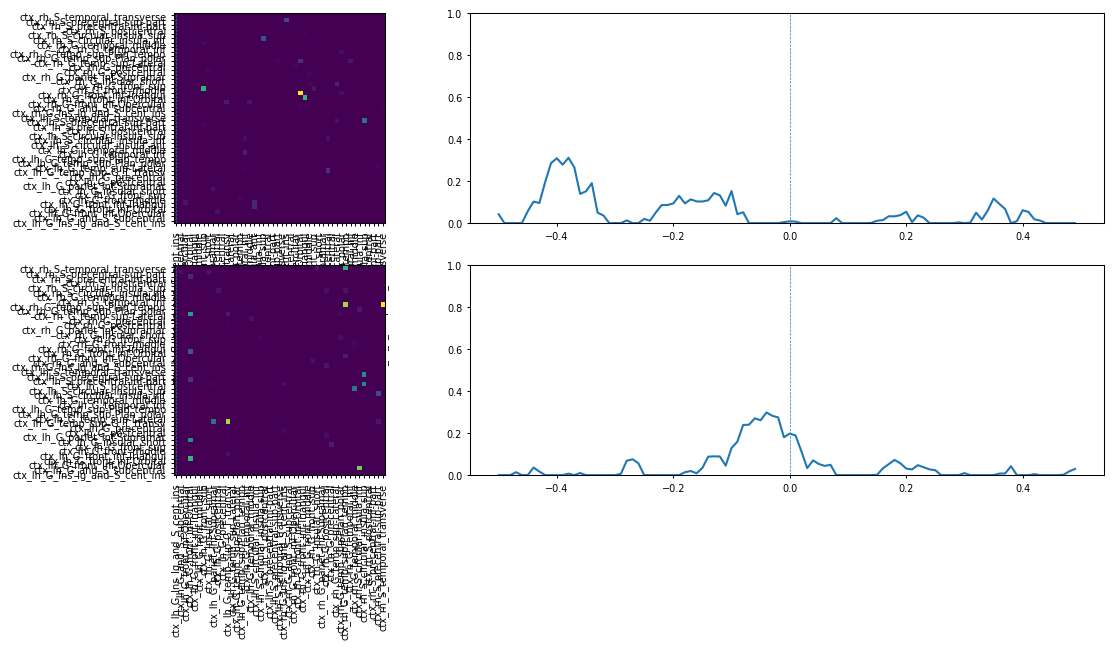

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={"width_ratios": [1, 3]})

i = 6

ax1[0].pcolormesh(
    perception_labels, 
    perception_labels,
    W_perception[..., i]
)

# rotate x axis labels
for label in ax1[0].get_xticklabels():
    label.set_rotation(90)

ax1[1].plot(perception_time, H_perception[i])
ax1[1].set_ylim(0,1)


ax2[0].pcolormesh(
    production_labels, 
    production_labels,
    W_production[..., i]
)

# rotate x axis labels
for label in ax2[0].get_xticklabels():
    label.set_rotation(90)

ax2[1].plot(production_time, H_production[i])
ax2[1].set_ylim(0,1)


for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    ax.axvline(0, lw=0.5, ls='dashed')

In [93]:
# 分析组件6的详细连接模式
def analyze_component_detailed(W_component, H_component, labels_list, times, component_idx=6, top_n=10):
    """详细分析特定组件的连接模式"""
    
    print(f"=== 组件 {component_idx} 详细分析 ===")
    
    # 时间动态分析
    h_values = H_component[component_idx, :]
    peak_times_idx = np.argsort(h_values)[-3:][::-1]  # 前3个峰值时间点
    peak_times = times[peak_times_idx]
    peak_values = h_values[peak_times_idx]
    
    print(f"\n时间动态特征:")
    print(f"  最大激活值: {np.max(h_values):.3f}")
    print(f"  平均激活值: {np.mean(h_values):.3f}")
    print(f"  前3个峰值时间点: {peak_times} s")
    print(f"  对应激活值: {peak_values}")
    
    # 空间连接分析
    conn_matrix = W_component[:, :, component_idx]
    
    # 获取top连接
    flat_conn = conn_matrix.flatten()
    top_indices = np.argsort(flat_conn)[-top_n:][::-1]
    
    print(f"\n前{top_n}个最强连接:")
    print("-" * 80)
    print(f"{'排名':<4} {'源区域':<25} {'目标区域':<25} {'连接强度':<10} {'功能类别':<15}")
    print("-" * 80)
    
    # 分析连接的功能类别
    connection_categories = {
        'motor_sensory': [],
        'frontal_temporal': [],
        'insula_related': [],
        'interhemispheric': [],
        'other': []
    }
    
    for idx, conn_idx in enumerate(top_indices):
        roi_i = conn_idx // len(labels_list)
        roi_j = conn_idx % len(labels_list)
        weight = flat_conn[conn_idx]
        
        src_label = labels_list[roi_i]
        tgt_label = labels_list[roi_j]
        
        # 功能分类
        category = 'other'
        if ('G_precentral' in src_label or 'S_precentral' in src_label or 
            'G_precentral' in tgt_label or 'S_precentral' in tgt_label or
            'G_postcentral' in src_label or 'S_postcentral' in src_label or
            'G_postcentral' in tgt_label or 'S_postcentral' in tgt_label):
            category = 'motor_sensory'
        elif ('G_front' in src_label or 'S_front' in src_label or
              'G_front' in tgt_label or 'S_front' in tgt_label):
            if ('temporal' in src_label or 'temporal' in tgt_label):
                category = 'frontal_temporal'
        elif ('insula' in src_label.lower() or 'insula' in tgt_label.lower()):
            category = 'insula_related'
        elif (('lh_' in src_label and 'rh_' in tgt_label) or 
              ('rh_' in src_label and 'lh_' in tgt_label)):
            category = 'interhemispheric'
            
        connection_categories[category].append((src_label, tgt_label, weight))
        
        category_display = {
            'motor_sensory': '运动感觉',
            'frontal_temporal': '额颞连接', 
            'insula_related': '脑岛相关',
            'interhemispheric': '半球间',
            'other': '其他'
        }[category]
        
        print(f"{idx+1:<4} {src_label[:24]:<25} {tgt_label[:24]:<25} {weight:<10.3f} {category_display:<15}")
    
    # 统计功能类别
    print(f"\n功能类别统计:")
    print("-" * 40)
    category_names = {
        'motor_sensory': '运动感觉网络',
        'frontal_temporal': '额颞网络',
        'insula_related': '脑岛网络', 
        'interhemispheric': '半球间连接',
        'other': '其他连接'
    }
    
    for category, connections in connection_categories.items():
        if connections:
            total_weight = sum(w for _, _, w in connections)
            print(f"{category_names[category]}: {len(connections)}个连接, 总权重: {total_weight:.3f}")
    
    return connection_categories

# 分析组件6 
categories = analyze_component_detailed(W_perception, H_perception, perception_labels, perception_time, component_idx=i)
# categories = analyze_component_detailed(W_production, H_production, production_labels, production_time, component_idx=i)

=== 组件 6 详细分析 ===

时间动态特征:
  最大激活值: 0.311
  平均激活值: 0.050
  前3个峰值时间点: [-0.38 -0.4  -0.41] s
  对应激活值: [0.3108737  0.30871699 0.28570977]

前10个最强连接:
--------------------------------------------------------------------------------
排名   源区域                       目标区域                      连接强度       功能类别           
--------------------------------------------------------------------------------
1    ctx_rh_G_front_inf-Trian  ctx_rh_G_front_inf-Orbit  0.471      其他             
2    ctx_rh_G_front_inf-Orbit  ctx_rh_G_front_inf-Trian  0.315      其他             
3    ctx_rh_G_front_middle     ctx_lh_G_front_sup        0.304      其他             
4    ctx_lh_S_precentral-sup-  ctx_rh_S_circular_insula  0.169      运动感觉           
5    ctx_rh_S_circular_insula  ctx_lh_S_circular_insula  0.116      脑岛相关           
6    ctx_rh_S_precentral-sup-  ctx_rh_G_Ins_lg_and_S_ce  0.105      运动感觉           
7    ctx_lh_G_temp_sup-G_T_tr  ctx_rh_G_postcentral      0.066      运动感觉           
8    ctx_rh_G_temp_s